## Style analyses

In [27]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import xgboost
import shap
from sklearn.preprocessing import RobustScaler
from src.colnames import topic_col, style_col
from utils import plot_volume, plot_style_timeseries

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
df = pd.read_json('data/topic/preds_extended.jsonl', 
                  orient='records',
                  lines=True)

In [34]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

### Preprocessing
Normalize absolute counts for hashtag, mentions, and emojis by dividing by the number of words.

In [35]:
for c in ['n_hashtag', 'n_mentions', 'n_emojis']:
    df[c] = df[c] / df['benoit_sentence-length-words']

Renaming variables into more readable names

In [36]:
readability_col = ['gunning_fog',
                   'automated_readability_index',
                   'coleman_liau_index',
                   'lix',
                   'rix']
length_col = ['n_characters', 'n_sentences']
style_targets = [c for c in df.columns if any(['rauh' in c, 
                                               'benoit' in c, 
                                               'alpha_ratio' in c])] + \
                ['n_hashtag', 'n_mentions', 'is_link', 'n_emojis'] + \
                readability_col + length_col
sentiment_targets = [c for c in df.columns if 'sentiment' in c]

In [37]:
new_names = ['% alphanumeric', 
             'frequency',
             'verb-to-noun ratio', 
             'Flesch-Kincaid Grade',
             'Flesch reading ease',
             '# words', 
             'sentence length (words)', 
             'sentence length (chars)', 
             'word length (syllables)',
             'word length (chars)', 
             '% nouns', 
             '% hashtag', '% mentions', 
             'has link', '% emojis',
             'Gunning Fog', 'Automated Readability Index', 'Coleman-Liau Index', 
             'LIX', 'RIX', '# characters', '# sentences',
             'negative sentiment', 'neutral sentiment', 'positive sentiment']

these, together with names of aggregate columns, are manually saved in `src/colnames.py`, under `new_style_col`

In [38]:
df = df.rename(dict(zip(style_targets + sentiment_targets, new_names)), axis=1)

Drop tweets for which metrics and undefined, and save reduced dataset.

In [39]:
df_reduced = df.copy()
df_reduced = df_reduced.dropna(subset=new_names)
df_reduced = df_reduced.drop(['% nouns'], axis=1)

In [40]:
df_reduced.to_json('data/topic/preds_reduced.jsonl', orient='records', lines=True)

Compute number of tweets dropped

In [24]:
df.shape[0] - df_reduced.shape[0]

3675

### Compute aggregate features for multi-feature metrics
We use PCA to reduce the multiple readability, sentence length, word length, and tweet length indices into one feature for each of these four variables.

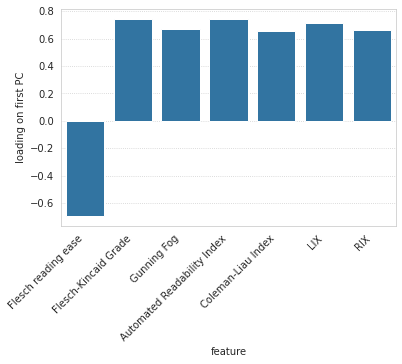

Explained variance ratio
[8.11451636e-01 8.03535087e-02 6.34911948e-02 2.14844986e-02
 1.44451201e-02 8.20085390e-03 5.73188045e-04]


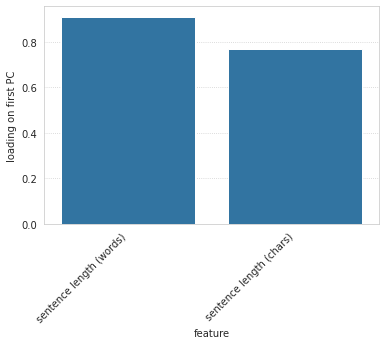

Explained variance ratio
[0.96543171 0.03456829]


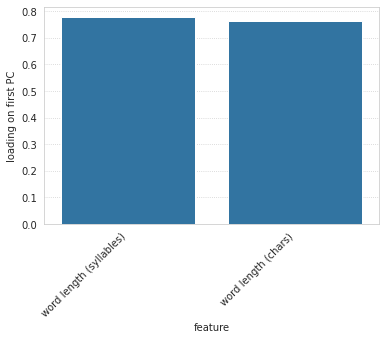

Explained variance ratio
[0.92219203 0.07780797]


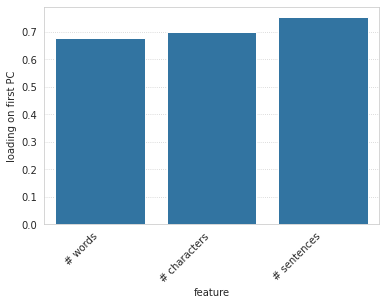

Explained variance ratio
[0.77832121 0.20659981 0.01507899]


In [41]:
import numpy as np
from sklearn.decomposition import PCA
reduce_sets = [['Flesch reading ease',
                'Flesch-Kincaid Grade',
                'Gunning Fog', 'Automated Readability Index', 
                'Coleman-Liau Index', 
                'LIX', 'RIX'],
               ['sentence length (words)',
                'sentence length (chars)'],
               ['word length (syllables)',
                'word length (chars)'],
               ['# words', '# characters', '# sentences',]]
new_names = ['reading complexity', 'sentence length', 'word length', 'tweet length']

for rs, nn in zip(reduce_sets, new_names):
    X = df_reduced[rs].dropna()
    X = RobustScaler().fit_transform(X) 
    pca = PCA(n_components=len(rs))
    pca.fit(X)
    df_reduced[nn] = pca.transform(X)[:,0]
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i}' 
                                                     for i in range(len(rs))], index=rs)
    loading_matrix = loading_matrix.reset_index().melt(id_vars='index')
    sns.barplot(data=loading_matrix[loading_matrix['variable']=='PC0'], 
                x='index', y='value', color=sns.color_palette()[0])
    plt.xlabel('feature')
    plt.ylabel('loading on first PC')
    plt.xticks(rotation=45, ha='right')
    plt.savefig(f'figs/pca/{nn}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('Explained variance ratio')
    print(pca.explained_variance_ratio_)

### Style metrics over time
Here we plot how style metrics evolved over time

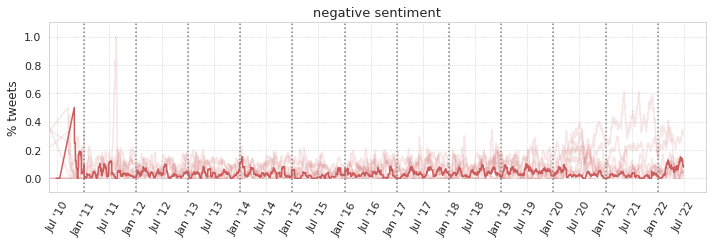

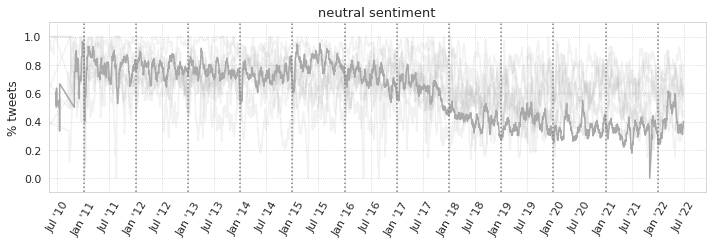

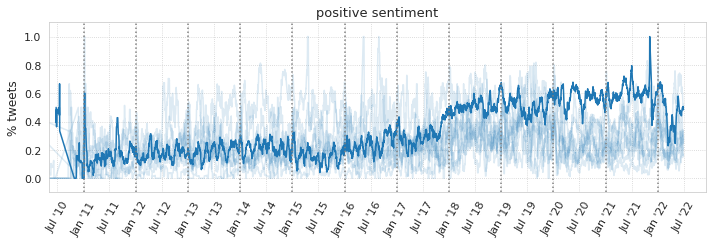

In [42]:
for c in [n for n in style_col if 'sentiment' in n]:
    if 'positive' in c:
        color = sns.color_palette()[0]
    elif 'neutral' in c:
        color = 'darkgrey'
    else:
        color = 'indianred'
    plot_style_timeseries(df_reduced, 
                          entities=df_reduced.entity.unique(),
                          colors=[color] * 9,
                          metric=c,
                          freq='D', 
                          roll_window=21,
                          normalized=False,
                          savename=f'sentiment_timeseries/{c}',
                          interactive=False,
                          title=f'{c}',
                          no_horizontal=True,
                          ylim=(-0.1,1.1),
                          figsize=(10,3.5), 
                          plot_smooth_only=True, 
                          legend=False)

For additional metrics, metrics are normalized to be zero-centered within each agency.

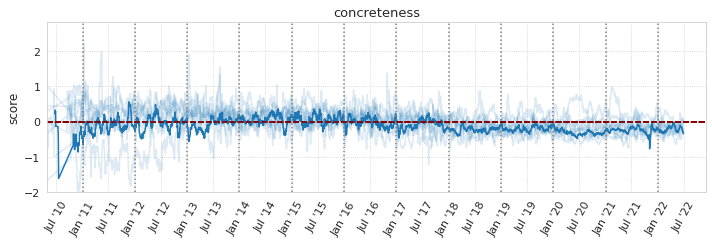

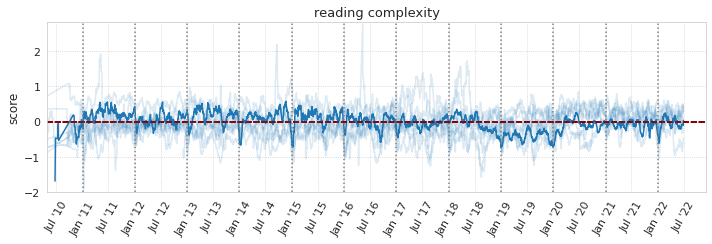

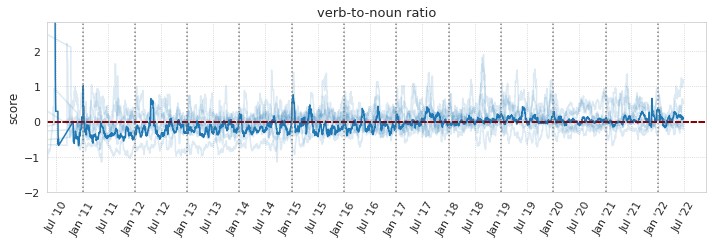

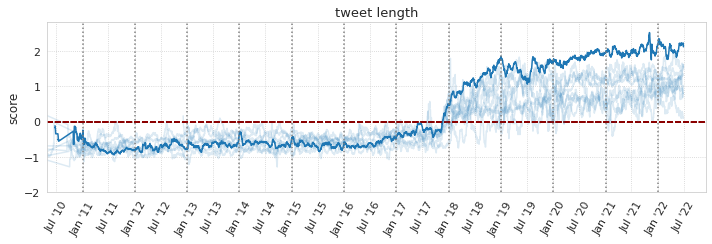

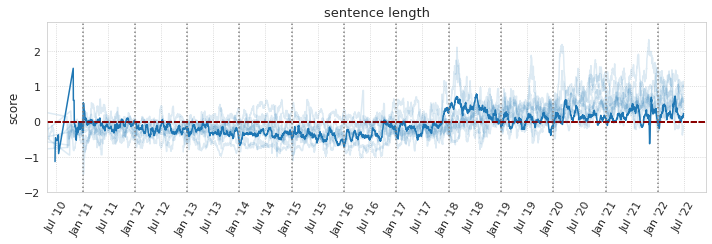

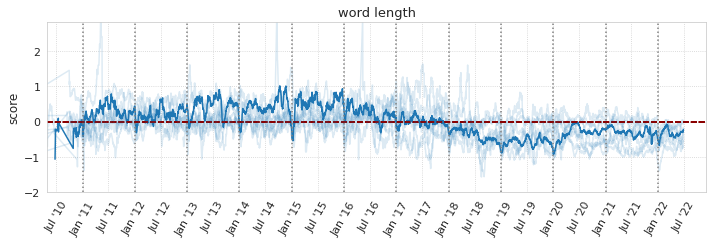

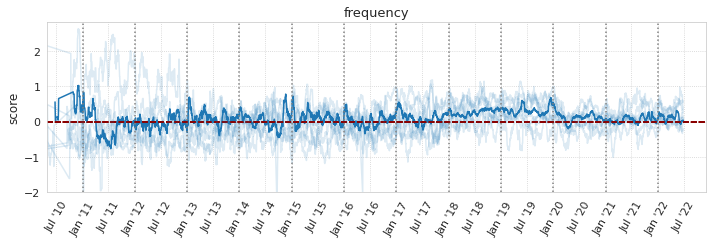

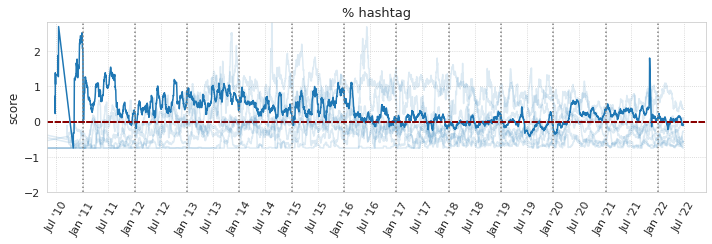

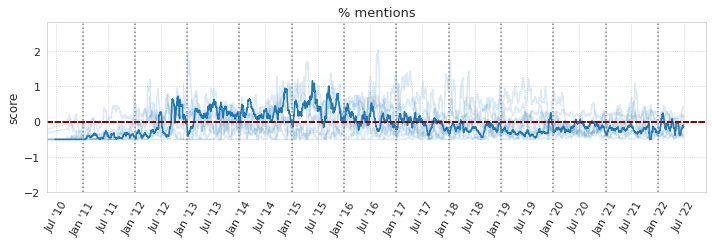

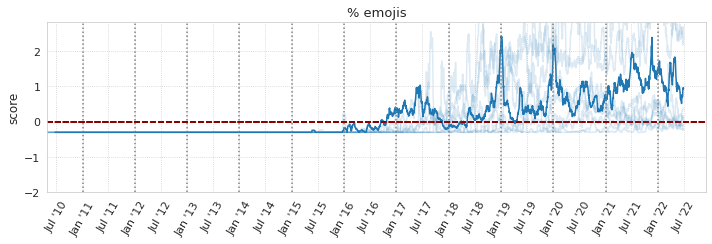

In [52]:
for i, c in enumerate(style_col):
    if 'sentiment' not in c:
        plot_style_timeseries(df_reduced, 
                              entities=df_reduced.entity.unique(),
                              colors = [sns.color_palette()[0]] * 9,
                              metric=c,
                              freq='D', 
                              roll_window=21,
                              normalized=True,
                              savename=f'style_timeseries/{c}',
                              plot_smooth_only=True,
                              interactive=False,
                              no_horizontal='mean',
                              ylim=(-2,2.8),
                              figsize=(10,3.5),
                              legend=False)

### Statistical comparison between EC and other agencies
In the following, we fit statistical models comparing the EC and other agencies along each of the style metrics. We fit one model per year to visualize progression. We start from 2014, as this is the first year for which we have data for all agencies.

In [48]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

coffs = range(2014,2023)

ests = []
for coff in coffs:
    for t in style_col:
        # print(t)
        scaler = RobustScaler()
        new_t_name = t.replace('-','_')
        new_t_name = new_t_name.replace(' ','_')
        new_t_name = new_t_name.replace('#','n')
        new_t_name = new_t_name.replace('%','prop')
        data = df_reduced[df_reduced['year']==coff].rename({t: new_t_name}, axis=1).fillna(0)
        data[new_t_name] = scaler.fit_transform(data[[new_t_name]])
        formula = f"{new_t_name} ~ C(entity, Treatment(reference='EU_Commission'))"

        # Specify model
        mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT()) # rlm

        # Freq workflow
        res = mod.fit()
        
        with open(f'summaries/style/{t}_{coff}.txt', 'w') as tfile:
            tfile.write((res.summary().as_latex()))

        # Save estimates
        est_df = pd.DataFrame(res.params, columns=['param'])
        est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", 
                                                       regex=True)
        est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
        est_df['target'] = t
        est_df['p_val'] = res.pvalues.values
        est_df = est_df[~est_df['predictor'].isin(topic_col)]
        est_df = est_df.reset_index(drop=True)
        est_df = est_df[est_df['predictor']!='Intercept']
        est_df['year'] = coff
        ests.append(est_df)

invalid value encountered in true_divide
Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.


In [49]:
categories = {'Concreteness': ['concreteness'], 
              'Reading Complexity': ['reading complexity'],
              'Action-orientedness': ['verb-to-noun ratio'], 
              'Overall Length': ['tweet length'],
              'Sentence Length': ['sentence length'],
              'Lexical Complexity': ['word length', 'frequency'],
              'Twitter-specific Features': ['% hashtag', 
                                            '% mentions', 
                                            '% emojis'],
              'Sentiment': ['negative sentiment', 
                            'positive sentiment', 
                            'neutral sentiment']}

In [50]:
ests = pd.concat(ests)
ests['param'] = ests['param'] * (ests['p_val']<0.05).astype(int)
ests.drop('p_val', axis=1, inplace=True)

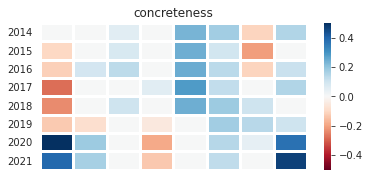

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


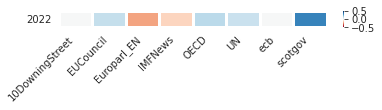

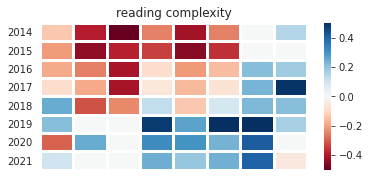

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


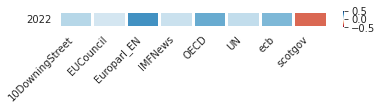

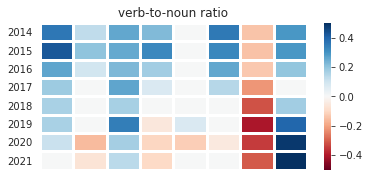

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


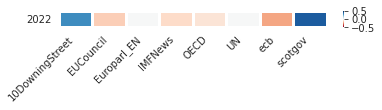

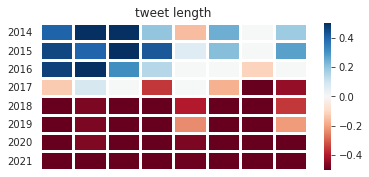

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


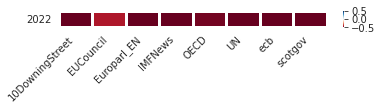

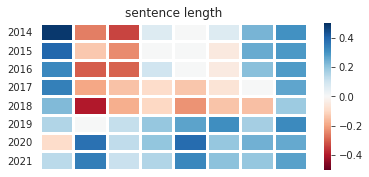

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


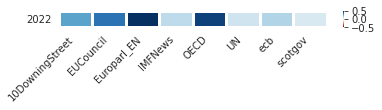

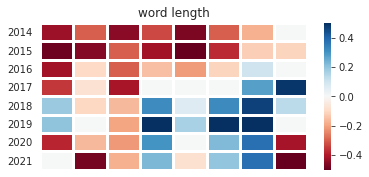

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


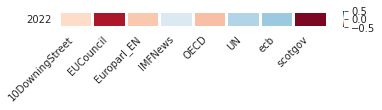

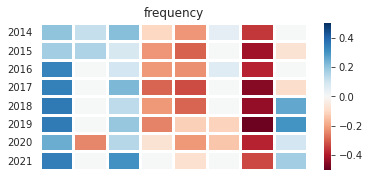

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


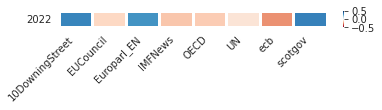

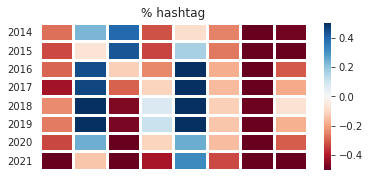

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


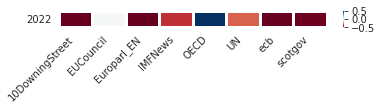

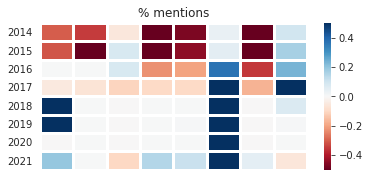

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


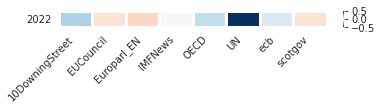

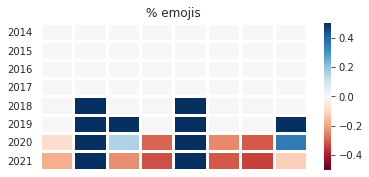

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


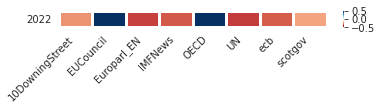

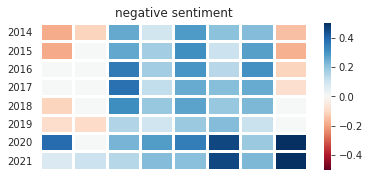

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


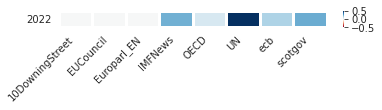

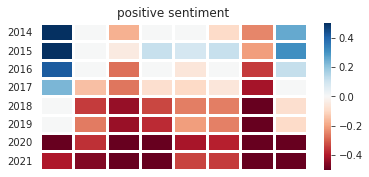

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


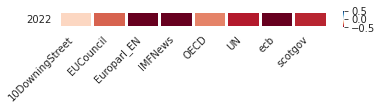

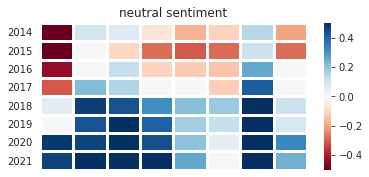

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


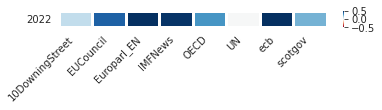

In [51]:
for k,v in categories.items():
    for vv in v:
        sub_grouped = ests[ests['target']==vv].drop('target', axis=1)
        sub_grouped = sub_grouped.pivot(index='predictor', columns='year').T # ests_wide.[[vv]].sort_values(by=vv).T
        sub_grouped.index = sub_grouped.index.get_level_values(1)
        plt.subplots(figsize=(6,0.3 * sub_grouped.shape[0]))
        ax = sns.heatmap(sub_grouped.iloc[:-1,:], cmap='RdBu', center=.0, 
                         linewidth=3, vmin=-.5, vmax=.5)
        plt.ylabel('')
        plt.xlabel('')
        plt.xticks(ticks=[], labels=[])
        plt.title(vv)
        plt.savefig(f'figs/heatmaps/{vv}_2021.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        plt.subplots(figsize=(6,0.3))
        ax = sns.heatmap(sub_grouped.iloc[-1:,:], cmap='RdBu', center=.0, 
                         linewidth=3, vmin=-.5, vmax=.5)
        plt.ylabel('')
        plt.xlabel('')
        plt.yticks(rotation=0)
        plt.xticks(labels=None, rotation=45, ha='right')
        plt.title('')
        plt.savefig(f'figs/heatmaps/{vv}_2022.png', dpi=300, bbox_inches='tight')
        
        sub_grouped.to_latex(f'summaries/style/{vv}.txt')
        
        plt.show()